In [169]:
import json
import pandas as pd
import numpy as np
from nltk.stem import SnowballStemmer

In [446]:
# Read Summarisation Model results from json file.

with open("../data/Model_Results/summarisation_results.jsonl", 'r') as json_file:
    json_list = list(json_file)

    
summarisationResults = {}
for json_str in json_list:
    
    result = json.loads(json_str)
    summaryList = sorted(result["sentence_scores"], key=lambda x:x[1], reverse=True)[:4]
    summary = ""
    for sentence in summaryList:
        summary += sentence[0] + ' '
    
    summarisationResults[result["id"]] = summary

In [447]:
summarisationData = pd.DataFrame(data=summarisationResults, index=[0])

In [448]:
summarisationDataDict = {}

for json_id in summarisationData.columns:
    
    features = {}
    
    features["summary"] = summarisationData[json_id].values[0]
    
    summarisationDataDict[json_id] = features

In [449]:
summarisationData = pd.DataFrame().from_dict(data=summarisationDataDict)

display(summarisationData)

,11972.json,11685.json,11096.json,5209.json,9524.json,5962.json,7070.json,1046.json,12849.json,13270.json,...,11576.json,3461.json,9464.json,10227.json,11707.json,3425.json,2977.json,294.json,3580.json,8384.json
summary,"""Building a wall"" on the border ""will take lit...","Those numbers show that as of October 2015, th...","If he did, he would have known that Senator Mc...","""…She supports taking $500 billion away from M...","Scott Walker helped run a ""criminal scheme"" to...",The campaign accurately quoted a figure whose ...,"So $30-31 million per year would, in fact, be ...",The Obama administration has emphasized many o...,"""It matters who’s leading the country, and it ...","Pence described the donors as major. ""The nati...",...,We’re not sure Sanders made that entirely clea...,"The $20 million designated for Cuba ""focuses o...",There also are no Asian or Pacific Islander Re...,"""The United States is in the longest stretch o...","""Secretary Clinton changes her position on thi...","Under the header ""New jobs created by the Stre...","They said low pay, increased work demands and ...","• Comstock, an adviser and frequent spokeswoma...","""House Republicans under Paul Ryan's leadershi...","""I will work in a bipartisan way to get it don..."


In [451]:
x_trainDf = pd.read_csv ('../data/Train_Eval_Test_Data/train.tsv', sep='\t')
x_trainDf.columns = ["json_id", "claim", "justification_label"]

x_testDf = pd.read_csv ('../data/Train_Eval_Test_Data/test.tsv', sep='\t')
x_testDf.columns = ["json_id", "claim", "justification_label"]

x_valDf = pd.read_csv ('../data/Train_Eval_Test_Data/val.tsv', sep='\t')
x_valDf.columns = ["json_id", "claim", "justification_label"]

In [452]:
x_trainDf["summary"] = ""
x_testDf["summary"]  = ""
x_valDf["summary"]   = ""

In [453]:
def addSummary(data, summaries):
    
    for index, row in data.iterrows():
        if row["json_id"] in summaries.columns:
            row["summary"] = summaries[row["json_id"]].values[0]

In [454]:
addSummary(x_trainDf, summarisationData)
addSummary(x_testDf, summarisationData)
addSummary(x_valDf, summarisationData)

In [455]:
y_trainDf = pd.DataFrame(data=x_trainDf["justification_label"])
y_testDf  = pd.DataFrame(data=x_testDf["justification_label"])
y_valDf   = pd.DataFrame(data=x_valDf["justification_label"])

In [456]:
def cleanAndStemm(sentence):
    
    sb = SnowballStemmer("english")
    
    sentenceList = []
    for token in sentence.split(' '):
        
        token = token.lower()
        token = sb.stem(token)
        
        sentenceList.append(token)
        
    newSentence = ' '.join(sentenceList)
    return newSentence

In [457]:
# Create list containing claims + attention explanations

trainClaimSumm  = []
yTrainLabels   = y_trainDf['justification_label'].tolist()

testClaimSumm   = []
yTestLabels    = y_testDf['justification_label'].tolist()

evalClaimSumm   = []
yEvalLabels    = y_valDf['justification_label'].tolist()

for index, row in x_trainDf.iterrows():
    trainClaimSumm.append(cleanAndStemm(row['claim']) + cleanAndStemm(row['summary']))

for index, row in x_testDf.iterrows():
    testClaimSumm.append(cleanAndStemm(row['claim']) + cleanAndStemm(row['summary']))

for index, row in x_valDf.iterrows():
    evalClaimSumm.append(cleanAndStemm(row['claim']) + cleanAndStemm(row['summary']))
    
totalClaimSumm = trainClaimSumm + testClaimSumm + evalClaimSumm
yTotalLabels = np.array(yTrainLabels + yTestLabels + yEvalLabels)

In [458]:
import nltk
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score

In [459]:
# Convert words to number using Bag of Words (Bow)
vectorizer = CountVectorizer(max_features=30)
vectorizedTrain = vectorizer.fit_transform(trainClaimSumm).toarray()
vectorizedTest  = vectorizer.fit_transform(testClaimSumm).toarray()
vectorizedEval  = vectorizer.fit_transform(evalClaimSumm).toarray()
vectorizedTotal = vectorizer.fit_transform(totalClaimSumm).toarray()

# Convert Bow values according to TfIdf
tfidfconverter = TfidfTransformer()
XTrain = tfidfconverter.fit_transform(vectorizedTrain).toarray()
XTest  = tfidfconverter.fit_transform(vectorizedTest).toarray()
XEval  = tfidfconverter.fit_transform(vectorizedEval).toarray()
XTotal = tfidfconverter.fit_transform(vectorizedTotal).toarray()

In [460]:
# Transform the data into a list of lists for the Word2Vec model

w2vTrainClaimSum = []
w2vTestClaimSum  = []
w2vEvalClaimSum  = []

for index, row in x_trainDf.iterrows():
    w2vTrainClaimSum.append((row['claim'] + row['summary']).split(" "))

for index, row in x_testDf.iterrows():
    w2vTestClaimSum.append((row['claim'] + row['summary']).split(" "))

for index, row in x_valDf.iterrows():
    w2vEvalClaimSum.append((row['claim'] + row['summary']).split(" "))


In [461]:
# Vectorize using Word2Vec

# min_count = 3 & size = 40 & window=8 & sg=1 

model = Word2Vec(sentences=w2vTrainClaimSum, min_count=3,size=40,workers=4, window=8, sg=1)

words = set(model.wv.index2word)
X_train_vect = np.array([np.array([model.wv[i] for i in ls if i in words])
                         for ls in w2vTrainClaimSum])
X_test_vect = np.array([np.array([model.wv[i] for i in ls if i in words])
                         for ls in w2vTestClaimSum])

X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))

<ipython-input-461-f86b847b1e84>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train_vect = np.array([np.array([model.wv[i] for i in ls if i in words])
<ipython-input-461-f86b847b1e84>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test_vect = np.array([np.array([model.wv[i] for i in ls if i in words])


              precision    recall  f1-score   support

  distortion       0.29      0.25      0.27         8
    emphasis       0.45      0.56      0.50         9
   unfounded       0.29      0.25      0.27         8

    accuracy                           0.36        25
   macro avg       0.34      0.35      0.34        25
weighted avg       0.35      0.36      0.35        25

0.36


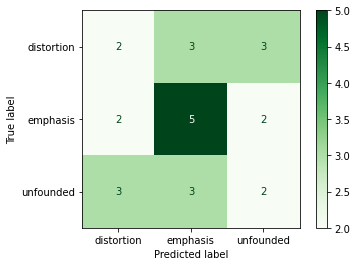

In [184]:
from sklearn.dummy import DummyClassifier

# Dummy Classifier With Method Stratified
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(XTrain, yTrainLabels)

yPredLabels = dummy_clf.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.33      0.12      0.18         8
    emphasis       0.38      0.67      0.48         9
   unfounded       0.50      0.38      0.43         8

    accuracy                           0.40        25
   macro avg       0.40      0.39      0.36        25
weighted avg       0.40      0.40      0.37        25

0.4


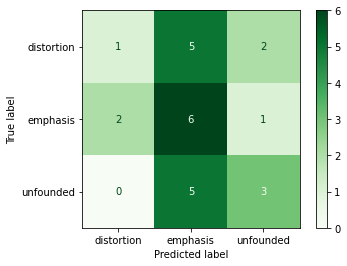

In [186]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classification Method
randForestClas = RandomForestClassifier(n_estimators=1000, random_state=0)
randForestClas.fit(XTrain,yTrainLabels)

yPredLabels = randForestClas.predict(XTest)

ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.40      0.29      0.33         7
    emphasis       0.22      0.29      0.25         7
   unfounded       0.29      0.29      0.29         7

    accuracy                           0.29        21
   macro avg       0.30      0.29      0.29        21
weighted avg       0.30      0.29      0.29        21

0.2857142857142857


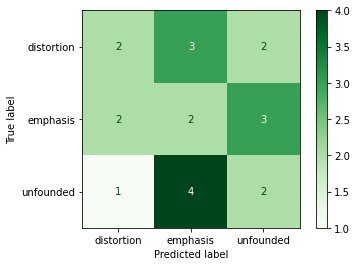

In [462]:
# Word 2 Vec

from sklearn.dummy import DummyClassifier

# Dummy Classifier With Method Stratified
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train_vect_avg, yTrainLabels)

yPredLabels = dummy_clf.predict(X_test_vect_avg)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.50      0.75      0.60         8
    emphasis       0.44      0.44      0.44         9
   unfounded       0.75      0.38      0.50         8

    accuracy                           0.52        25
   macro avg       0.56      0.52      0.51        25
weighted avg       0.56      0.52      0.51        25

0.52


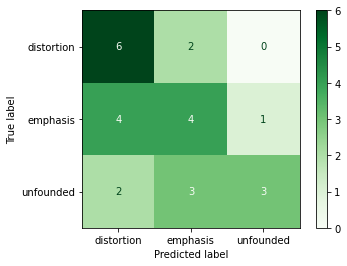

In [188]:
from sklearn.neighbors import KNeighborsClassifier

# K-Neighbors Classifier
kNeighborsClas = KNeighborsClassifier(n_neighbors=2)
kNeighborsClas.fit(XTrain,yTrainLabels)

yPredLabels = kNeighborsClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.38      0.43      0.40         7
    emphasis       0.18      0.29      0.22         7
   unfounded       0.00      0.00      0.00         7

    accuracy                           0.24        21
   macro avg       0.19      0.24      0.21        21
weighted avg       0.19      0.24      0.21        21

0.23809523809523808


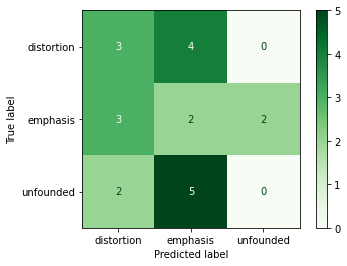

In [463]:
# Word2Vec

from sklearn.neighbors import KNeighborsClassifier

# K-Neighbors Classifier
kNeighborsClas = KNeighborsClassifier(n_neighbors=2)
kNeighborsClas.fit(X_train_vect_avg,yTrainLabels)

yPredLabels = kNeighborsClas.predict(X_test_vect_avg)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.50      0.50      0.50         8
    emphasis       0.38      0.56      0.45         9
   unfounded       0.25      0.12      0.17         8

    accuracy                           0.40        25
   macro avg       0.38      0.39      0.37        25
weighted avg       0.38      0.40      0.38        25

0.4


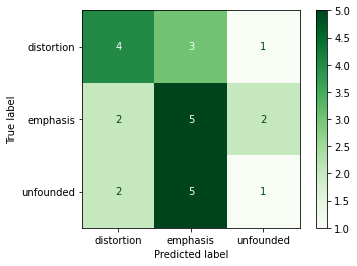

In [92]:
from sklearn.svm import SVC

# SVM Classifier
svmClas = SVC()
svmClas.fit(XTrain,yTrainLabels)

yPredLabels = svmClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.35      1.00      0.52         7
    emphasis       1.00      0.14      0.25         7
   unfounded       0.00      0.00      0.00         7

    accuracy                           0.38        21
   macro avg       0.45      0.38      0.26        21
weighted avg       0.45      0.38      0.26        21

0.38095238095238093


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


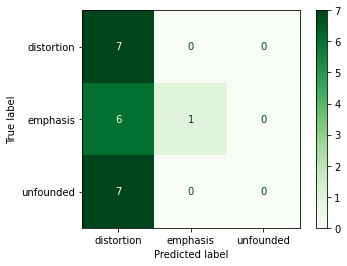

In [464]:
# Word2Vec

from sklearn.svm import SVC

# SVM Classifier
svmClas = SVC()
svmClas.fit(X_train_vect_avg,yTrainLabels)

yPredLabels = svmClas.predict(X_test_vect_avg)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.38      0.38      0.38         8
    emphasis       0.27      0.33      0.30         9
   unfounded       0.17      0.12      0.14         8

    accuracy                           0.28        25
   macro avg       0.27      0.28      0.27        25
weighted avg       0.27      0.28      0.27        25

0.28


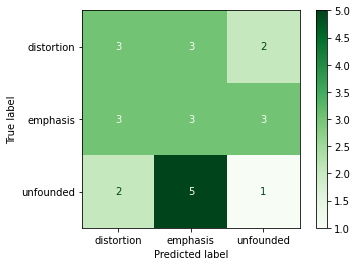

In [93]:
from sklearn.gaussian_process import GaussianProcessClassifier

# Gaussian Process Classifier
gaussianProcClas = GaussianProcessClassifier()
gaussianProcClas.fit(XTrain,yTrainLabels)

yPredLabels = gaussianProcClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.29      0.57      0.38         7
    emphasis       0.00      0.00      0.00         7
   unfounded       0.00      0.00      0.00         7

    accuracy                           0.19        21
   macro avg       0.10      0.19      0.13        21
weighted avg       0.10      0.19      0.13        21

0.19047619047619047


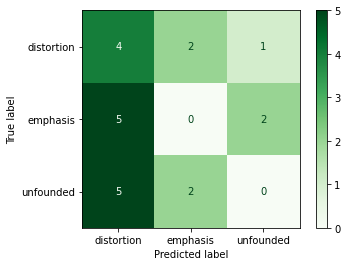

In [465]:
# Word2Vec

from sklearn.gaussian_process import GaussianProcessClassifier

# Gaussian Process Classifier
gaussianProcClas = GaussianProcessClassifier()
gaussianProcClas.fit(X_train_vect_avg,yTrainLabels)

yPredLabels = gaussianProcClas.predict(X_test_vect_avg)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.36      0.50      0.42         8
    emphasis       0.40      0.22      0.29         9
   unfounded       0.33      0.38      0.35         8

    accuracy                           0.36        25
   macro avg       0.37      0.37      0.35        25
weighted avg       0.37      0.36      0.35        25

0.36


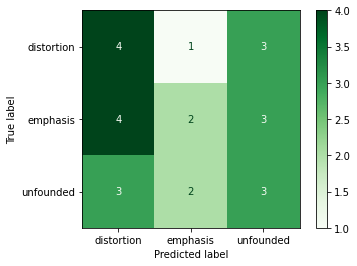

In [94]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier
decisionTreeClas = DecisionTreeClassifier()
decisionTreeClas.fit(XTrain,yTrainLabels)

yPredLabels = decisionTreeClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.20      0.14      0.17         7
    emphasis       0.29      0.29      0.29         7
   unfounded       0.44      0.57      0.50         7

    accuracy                           0.33        21
   macro avg       0.31      0.33      0.32        21
weighted avg       0.31      0.33      0.32        21

0.3333333333333333


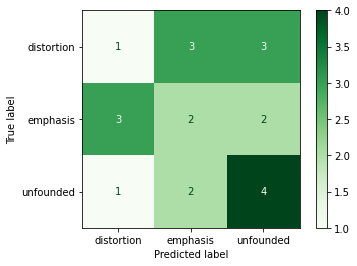

In [466]:
# Word2Vec

from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier
decisionTreeClas = DecisionTreeClassifier()
decisionTreeClas.fit(X_train_vect_avg,yTrainLabels)

yPredLabels = decisionTreeClas.predict(X_test_vect_avg)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.50      0.12      0.20         8
    emphasis       0.35      0.67      0.46         9
   unfounded       0.00      0.00      0.00         8

    accuracy                           0.28        25
   macro avg       0.28      0.26      0.22        25
weighted avg       0.29      0.28      0.23        25

0.28


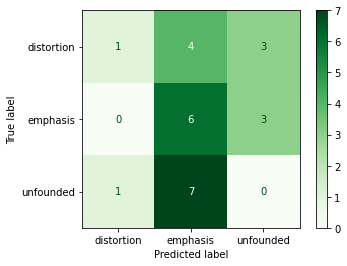

In [95]:
from sklearn.ensemble import AdaBoostClassifier

# Ada Boost Classifier
adaBoostClas = AdaBoostClassifier()
adaBoostClas.fit(XTrain,yTrainLabels)

yPredLabels = adaBoostClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.17      0.14      0.15         7
    emphasis       0.17      0.14      0.15         7
   unfounded       0.44      0.57      0.50         7

    accuracy                           0.29        21
   macro avg       0.26      0.29      0.27        21
weighted avg       0.26      0.29      0.27        21

0.2857142857142857


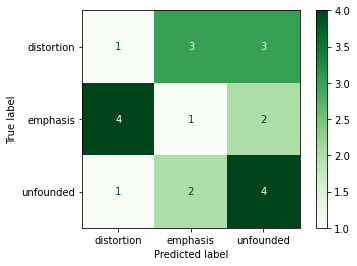

In [467]:
# Word2Vec
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier
decisionTreeClas = DecisionTreeClassifier()
decisionTreeClas.fit(X_train_vect_avg,yTrainLabels)

yPredLabels = decisionTreeClas.predict(X_test_vect_avg)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.57      0.50      0.53         8
    emphasis       0.40      0.22      0.29         9
   unfounded       0.46      0.75      0.57         8

    accuracy                           0.48        25
   macro avg       0.48      0.49      0.46        25
weighted avg       0.47      0.48      0.46        25

0.48


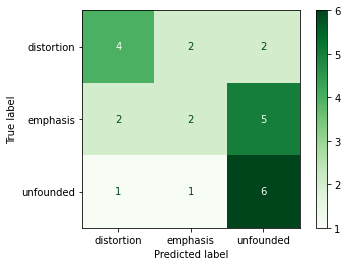

In [96]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes Classifier
gaussianNBClas = GaussianNB()
gaussianNBClas.fit(XTrain,yTrainLabels)

yPredLabels = gaussianNBClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.00      0.00      0.00         7
    emphasis       0.30      0.43      0.35         7
   unfounded       0.44      0.57      0.50         7

    accuracy                           0.33        21
   macro avg       0.25      0.33      0.28        21
weighted avg       0.25      0.33      0.28        21

0.3333333333333333


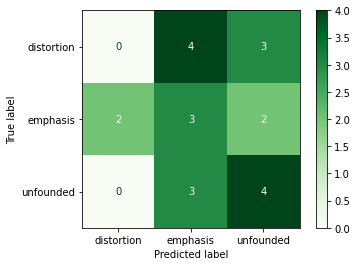

In [468]:
# Word2Vec

from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier
decisionTreeClas = DecisionTreeClassifier()
decisionTreeClas.fit(X_train_vect_avg,yTrainLabels)

yPredLabels = decisionTreeClas.predict(X_test_vect_avg)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.29      0.25      0.27         8
    emphasis       0.30      0.33      0.32         9
   unfounded       0.12      0.12      0.12         8

    accuracy                           0.24        25
   macro avg       0.24      0.24      0.24        25
weighted avg       0.24      0.24      0.24        25

0.24


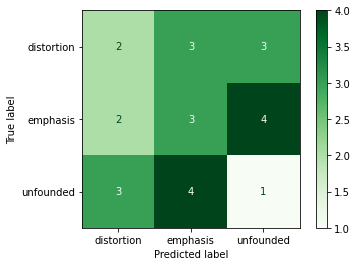

In [97]:
from sklearn.naive_bayes import MultinomialNB
# Multinomial Naive Bayes Classifier
multiNBClas = MultinomialNB()
multiNBClas.fit(XTrain,yTrainLabels)

yPredLabels = multiNBClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.29      0.25      0.27         8
    emphasis       0.00      0.00      0.00         9
   unfounded       0.41      0.88      0.56         8

    accuracy                           0.36        25
   macro avg       0.23      0.38      0.28        25
weighted avg       0.22      0.36      0.26        25

0.36


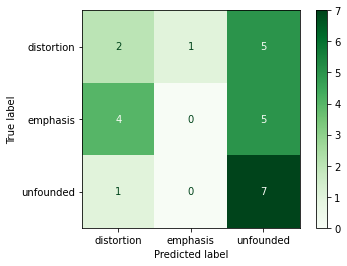

In [443]:
from sklearn.linear_model import SGDClassifier
# Multinomial Naive Bayes Classifier
sgdClas = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42,max_iter=5, tol=None)
sgdClas.fit(XTrain,yTrainLabels)

yPredLabels = sgdClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.00      0.00      0.00         7
    emphasis       0.00      0.00      0.00         7
   unfounded       0.33      1.00      0.50         7

    accuracy                           0.33        21
   macro avg       0.11      0.33      0.17        21
weighted avg       0.11      0.33      0.17        21

0.3333333333333333


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


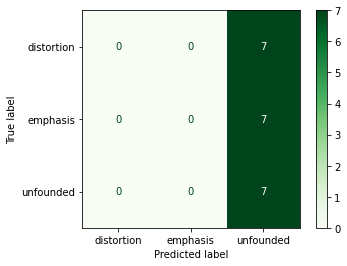

In [469]:
# Word2Vec
from sklearn.linear_model import SGDClassifier
# Multinomial Naive Bayes Classifier
sgdClas = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42,max_iter=5, tol=None)
sgdClas.fit(X_train_vect_avg,yTrainLabels)

yPredLabels = sgdClas.predict(X_test_vect_avg)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.20      0.12      0.15         8
    emphasis       0.33      0.44      0.38         9
   unfounded       0.25      0.25      0.25         8

    accuracy                           0.28        25
   macro avg       0.26      0.27      0.26        25
weighted avg       0.26      0.28      0.27        25

0.28


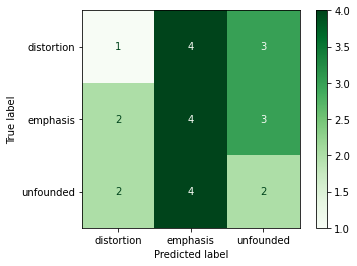

In [423]:
from sklearn.linear_model import LogisticRegression
# Logistic Regression
logRegClas = LogisticRegression()
logRegClas.fit(XTrain,yTrainLabels)

yPredLabels = logRegClas.predict(XTest)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))

              precision    recall  f1-score   support

  distortion       0.25      0.57      0.35         7
    emphasis       0.00      0.00      0.00         7
   unfounded       0.00      0.00      0.00         7

    accuracy                           0.19        21
   macro avg       0.08      0.19      0.12        21
weighted avg       0.08      0.19      0.12        21

0.19047619047619047


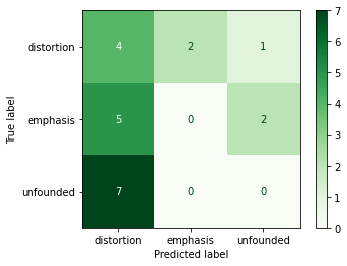

In [470]:
# Word2Vec
from sklearn.linear_model import LogisticRegression
# Logistic Regression
logRegClas = LogisticRegression()
logRegClas.fit(X_train_vect_avg,yTrainLabels)

yPredLabels = logRegClas.predict(X_test_vect_avg)

# Evaluate Results
ConfusionMatrixDisplay.from_predictions(yTestLabels, yPredLabels, cmap='Greens')
print(classification_report(yTestLabels,yPredLabels))
print(accuracy_score(yTestLabels,yPredLabels))